## Clone the Repository

In [1]:
!git clone https://github.com/sovit-123/fastercnn-pytorch-training-pipeline.git

Cloning into 'fastercnn-pytorch-training-pipeline'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 320 (delta 21), reused 20 (delta 20), pack-reused 282
Receiving objects: 100% (320/320), 1.46 MiB | 3.32 MiB/s, done.
Resolving deltas: 100% (182/182), done.


We will execute all the code within the cloned project directory, that is `fastercnn-pytorch-training-pipeline`.

In [2]:
# Enter the repo directory.
%cd fastercnn-pytorch-training-pipeline/

/kaggle/working/fastercnn-pytorch-training-pipeline


In [3]:
# Install the Requirements
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - \ | / done
  Preparing metadata (pyproject.toml) ... - \ | / - done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370021 sha256=cad930f616670443825e097416832b928cb33294098133037045486ce697584d
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.4.60
    Uninstalling opencv-python-headless-4.5.4.60:
      Successfully uninstalled opencv-python-headless-4.5.4.60
  Attemptin

## Download the Dataset

Here we are using the [Aquarium Dataset](https://public.roboflow.com/object-detection/aquarium) from Roboflow.

Download the unzip the dataset to `custom_data` directory.

In [4]:
!curl -L "https://public.roboflow.com/ds/CNyGy97q45?key=eSpwiC1Ah7" > roboflow.zip; unzip roboflow.zip -d custom_data; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1596      0 --:--:-- --:--:-- --:--:--  1596
100 68.0M  100 68.0M    0     0  43.5M      0  0:00:01  0:00:01 --:--:--  104M
Archive:  roboflow.zip
 extracting: custom_data/README.dataset.txt  
 extracting: custom_data/README.roboflow.txt  
   creating: custom_data/test/
 extracting: custom_data/test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
 extracting: custom_data/test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.xml  
 extracting: custom_data/test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
 extracting: custom_data/test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.xml  
 extracting: custom_data/test/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
 extracting: custom_data/test/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.xml

## Create the Custom Dataset YAML File

The YAML file should contain:
* `TRAIN_DIR_IMAGES`: Path to the training images directory.
* `TRAIN_DIR_LABELS`: Path to the training labels directory containing the XML files. Can be the same as `TRAIN_DIR_IMAGES`.
* `VALID_DIR_IMAGES`: Path to the validation images directory.
* `VALID_DIR_LABELS`: Path to the validation labels directory containing the XML files. Can be the same as `VALID_DIR_IMAGES`.
* `CLASSES`: All the class names in the dataset along with the `__background__` class as the first class.
* `NC`: The number of classes. This should be the number of classes in the dataset + the background class. If the number of classes in the dataset are 7, then `NC` should be 8.
* `SAVE_VALID_PREDICTION_IMAGES`: Whether to save the prediction results from the validation loop or not.

In [5]:
%%writefile data_configs/custom_data.yaml
# Images and labels direcotry should be relative to train.py
TRAIN_DIR_IMAGES: 'custom_data/train'
TRAIN_DIR_LABELS: 'custom_data/train'
VALID_DIR_IMAGES: 'custom_data/valid'
VALID_DIR_LABELS: 'custom_data/valid'

# Class names.
CLASSES: [
    '__background__',
    'fish', 'jellyfish', 'penguin', 
    'shark', 'puffin', 'stingray',
    'starfish'
]

# Number of classes (object classes + 1 for background class in Faster RCNN).
NC: 8

# Whether to save the predictions of the validation set while training.
SAVE_VALID_PREDICTION_IMAGES: True

Writing data_configs/custom_data.yaml


## Training

For this training example we use:
* The official Faster RCNN ResNet50 FPN model.
* Batch size of 8. You may change it according to the GPU memory available.

In [6]:
# Train the Aquarium dataset for 30 epochs.
!python train.py --config data_configs/custom_data.yaml --epochs 30 --model fasterrcnn_resnet50_fpn --project-name custom_training --batch-size 8

Removing custom_data/train/IMG_3133_jpeg_jpg.rf.f439b9d382fd153b96f0a88cdf169172.xml and corresponding custom_data/train/IMG_3133_jpeg_jpg.rf.f439b9d382fd153b96f0a88cdf169172.jpg
custom_data/train/IMG_3133_jpeg_jpg.rf.f439b9d382fd153b96f0a88cdf169172.xml not found...
Removing IMG_3133_jpeg_jpg.rf.f439b9d382fd153b96f0a88cdf169172.jpg image
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Number of training samples: 447
Number of validation samples: 127

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/faste

## Visualize Validation Results

Check out a few validation results from `outputs/training/custom_training` directory.

In [7]:
import matplotlib.pyplot as plt
import glob as glob

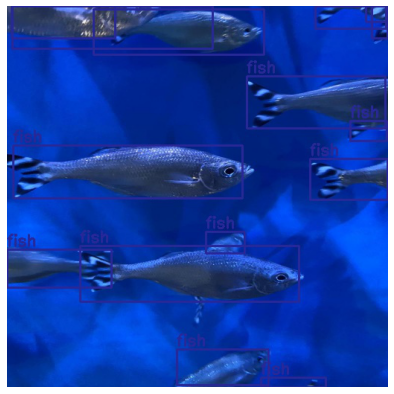

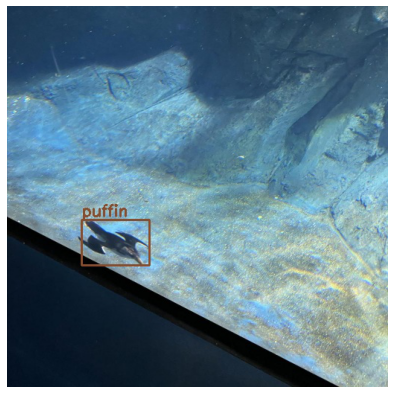

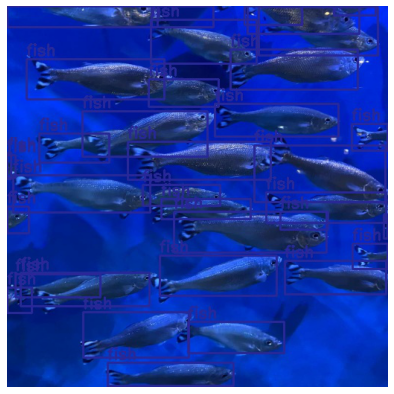

In [8]:
results_dir_path = 'outputs/training/custom_training'
valid_images = glob.glob(f"{results_dir_path}/*.jpg")

for i in range(3):
    plt.figure(figsize=(10, 7))
    image = plt.imread(valid_images[i])
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Check Out the Repo for Latest Updates

https://github.com/sovit-123/fastercnn-pytorch-training-pipeline